# PROPOSAL (WIP)

This notebook shows how one can combine this library with
[PROPOSAL](https://github.com/tudo-astroparticlephysics/PROPOSAL)
to simulate the detection of leptons traveling through water via Cherenkov light.

It also functions as a hands-on tutorial on what a simulation pipeline using
this library can look like.

(work in progress)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hephaistos.pipeline as pl
import proposal as pp
import theia
import theia.units as u

## Setup Propagator

Here we just reproduce the setup of PROPOSAL as described here:
https://github.com/tudo-astroparticlephysics/PROPOSAL/blob/master/examples/AdvancedPropagator.ipynb

In [2]:
from pathlib import Path

# pp.InterpolationSettings.tables_path = "/tmp"
pp.InterpolationSettings.tables_path = str(Path.home() / "proposal")

In [3]:
args = {
    "particle_def": pp.particle.MuMinusDef(),
    "target": pp.medium.AntaresWater(),
    "interpolate": True,
    "cuts": pp.EnergyCutSettings(np.inf, 0.05, False),
}
cross = pp.crosssection.make_std_crosssection(**args)

In [4]:
collection = pp.PropagationUtilityCollection()

collection.displacement = pp.make_displacement(cross, True)
collection.interaction = pp.make_interaction(cross, True)
collection.time = pp.make_time(cross, args["particle_def"], True)

utility = pp.PropagationUtility(collection=collection)

In [5]:
geometry = pp.geometry.Box(pp.Cartesian3D(0,0,0), 1e20, 1e20, 1e20)
density_distr = pp.density_distribution.density_homogeneous(args["target"].mass_density)

In [6]:
prop = pp.Propagator(args["particle_def"], [(geometry, utility, density_distr)])

## Setup Photon Simulation

Next up is the creation of the simulation pipeline.

Now here's the juicy part where we setup the photon simulation pipeline
and create some estimations. We start with some configuration to have them in
one place.

In [7]:
# light settings
lambdaRange = (400.0, 800.0) * u.nm

# tracing settings
batchSize = 2**20 # ~ 1 Mio rays
nScatter = 6
t_max = 1000.0 * u.ns

# estimator settings
nBins = 200
binSize = 5.0 * u.ns
t0 = 0.0 * u.ns

# schedule settings
runsPerTarget = 5

### Media creation

Our detector setup consists of multiple glass spheres submerged in water.
So naturally, we start with creating media for water and glass each.

There's a ready made glass model for BK7 glass, but the water we have to
plunge together ourselves. For that one can use the `WaterBaseModel` for the
optical properties and a phase function for scattering. Since it's easier, we'll
use `HenyeyGreensteinPhaseFunction`, but for accurate water modeling one should
prefer `FournierForandPhaseFunction` instead. Since internally all `Medium` are
essentially a collection of lookup tables, lastly we also inherit from
`MediumModel` which provides a convenient function to sample the analytic
functions.

In [8]:
class WaterModel(
    theia.material.WaterBaseModel,
    theia.material.HenyeyGreensteinPhaseFunction,
    theia.material.MediumModel,
):
    def __init__(self) -> None:
        theia.material.WaterBaseModel.__init__(self, 5.0, 1000.0, 35.0)
        theia.material.HenyeyGreensteinPhaseFunction.__init__(self, 0.6)

    ModelName = "water"

In [9]:
# call createMedium() to convert analytic model to sampled one
water = WaterModel().createMedium()
glass = theia.material.BK7Model().createMedium()

We can now use the media to create materials. When we later add geometries,
they'll define an inside and an outside. Materials assign to both volumes a
medium and some flags controlling the simulations behavior when a ray hits it.
In our case we have water outside and glass inside. We also mark the inward
direction as detector to generate hits and mark the outside direction as
absorber to stop rays originating from within the detector to propagate and
eventually creating hits. Since light sources won't check wether they're inside
detector geometries, this ensures we wont simulate nonsensical rays. See
`MaterialFlags` and `parseMaterialFlags` for what the literals means.

In [10]:
material = theia.material.Material("mat", glass, water, flags=("D", "B"))

Currently these models live on the CPU, but we need to get them to the GPU in
order to be usable by the simulation pipeline. `MediaStore` does that for us.
It optionally also allows to update material and media, but we don't need that
here.

In [11]:
matStore = theia.material.MaterialStore([material])

### Scene Creation

Before talking about scenes, we first need to introduce the notion of geometries.
A geometry is a triangulated polygon of any shape separating two volumes. Each
vertex of the polygon stores beside its position also a normal direction, which
by definition points outwards and therefore allow to label the two volumes as
inside and outside. Furthermore, the normals allow to approximate smooth
surfaces as they are interpolated over a triangles surface.

To allow hardware accelerated ray tracing against geometries they first need to be
processed. This happens in `MeshStore`. It also allows to reuse similar shapes,
e.g. in our case all our detectors are spheres so we only need to store a single
sphere. Later on one create multiple instances from a single mesh (shape) and
assign an affine transformation to each including scaling and rotation. See
`Transformation` for a util class creating such transformations.

Now let's start with creating a sphere mesh and populate a `MeshStore` with it.

In [12]:
# load sphere model from disk
meshStore = theia.scene.MeshStore({
    "sphere": "../assets/sphere.stl"
})

To use the geometries in a scene, one needs to create instances of them.
Each instance also takes a material and transformation. Additionally, in case
the geometry is a detector it also stores a `detectorId` to distinguish them.
Since hits are recorded in geometry local coordinates, i.e. the reverse
transformation is applied, they can't distinguish detectors by hit position.

Besides mesh instances, a scene holds some additional information. It defines
a boundary box outside which ray tracing is stopped, a medium all instances are
submerged in (note that the outside medium of the instance as defined by its
material must match this) and finally targets, which are spheres some tracing
algorithms use to aid the tracing simulation to ensure a higher hit rate.

Hopefully, the creation of a scene is (somewhat) intuitive so let's dig right in.

In [13]:
# here we define the positions of our detectors
positions = np.array([
    (0.0, 0.0, 0.0),
    (0.0, 0.0, 20.0),
    (0.0, 0.0, 40.0),
    (0.0, 0.0, 60.0),
    (0.0, 0.0, 80.0),
    (0.0, 0.0, 100.0),
]) * u.m
radius = 50.0 * u.cm

In [14]:
# to make it more readable create transformations separately
transforms = [
    theia.scene.Transform.Scale(radius, radius, radius).translate(*pos)
    for pos in positions
]
# finally create our scene
scene = theia.scene.Scene(
    [
        meshStore.createInstance("sphere", "mat", transform=t, detectorId=i)
        for i, t in enumerate(transforms)
    ], # instances
    matStore.material, # material dict for lookups
    medium=matStore.media["water"], # scene medium
    bbox=theia.scene.RectBBox((-1. * u.km,) * 3, (1. * u.km,) * 3),
    targets=[theia.scene.SphereBBox(pos, radius) for pos in positions]
)

### Pipeline Creation

Last step before doing actual simulation is to define the simulation pipeline.
The pipeline API is from `hephaistos`, the underlying GPGPU framework, but fits
here nicely as it allows to plug different models into a single "program".

A typical light simulation pipeline consists of the following stages:
- Random Number Generator
- Light Source
- Ray Tracer
- Estimator

The first three should be self explanatory. The last one, the estimator is
nothing to fancy either: It simply consumes the hits generated by the tracer
and creates a final product. This can be the hits copied back to the CPU or
(what we'll use) a histogram.
Since tracers usually only create hits for a single detector per run, this is
rather easy.

Quick note on why tracers usually only create hits for one detector:
They all try to "aim" for a specific detector so we expect to have mostly hits
from a single detector anyway, but this also make things like the histogram
estimator easier and provides an obvious way to split work across multiple GPUs.
This aiming is especially useful for forcing the tracer to generate hits on
distant detectors.

#### Random Number Generator

Theia currently comes with two random number generators:
- `PhiloxRNG`: Counter based pseudo random number generator
- `SobolQRNG`: Scrambled Sobol sequence (lookup RQMC)

While the scrambled Sobol is a bit slower, it creates higher quality random
number usually resulting in a much higher converging rate of the MC estimate
(O(N^-1) instead of O(N^-1/2)).

In [15]:
rng = theia.random.SobolQRNG(seed=0xC001C0FFEE)

#### Light Source

There are already multiple light source available and one can even define a
custom one with a bit of shader code. For our case there's already a light
source simulating the Cherenkov light from a particle track:
`CherenkovTrackLightSource`.
It allows to define a photon source for sampling wavelengths, which can be used
to importance sample the detector response. Here we'll just a uniform wavelength
distribution. Of course the individual energy/photon count transported is still
calculated using the Frank-Tamm formula.

In [16]:
# allocate memory for the track; we'll fit it later
# let's allocate enough for 100 vertices, which hopefully is much more than we need
track = theia.light.ParticleTrack(100)
# create light source
photons = theia.light.UniformPhotonSource(
    lambdaRange=lambdaRange,
    timeRange=(0.0,0.0) # disable photon time sampling (separate from track time)
)
light = theia.light.CherenkovTrackLightSource(
    photons, track,
    medium=matStore.media["water"],
    usePhotonCount=True,
)

#### Tracer

A tracer uses the light source to sample light rays it then propagates. If such
a ray hits the specified detector it creates a hit and pass it to the response
function, here it's just a simple Lambertian response, but you can create your
own with a little bit of shader code.

There are different tracing algorithms each with their own pros and cons.
We're going to use `SceneShadowTracer` as our detectors are not occluded by
other geometry.

In [17]:
response = theia.estimator.UniformHitResponse()
tracer = theia.trace.SceneShadowTracer(
    batchSize,
    light,
    response,
    rng,
    scene=scene,
    nScattering=nScatter,
    maxTime=t_max,
)

We'll also tell the RNG to advance the stream by the amount the tracer draws per
batch so we don't have to do that ourselves. (`tracer.nRNGSamples` already
includes the amount of samples the light source draws)

In [18]:
rng.autoAdvance = tracer.nRNGSamples

#### Estimator

An estimator takes the hits produced by the tracer and creates a final
product. This could be simply copying back the hits to the CPU, but since the
data is already on the GPU, we'll create the histogram there.

In [19]:
estimator = theia.estimator.HistogramEstimator(
    response.queue,
    nBins=nBins,
    t0=t0,
    binSize=binSize,
    normalization=tracer.normalization,
)

#### Putting it all together

Finally, we take all this stages and create our pipeline.

In [20]:
pipeline = pl.Pipeline([
    rng,
    photons,
    light,
    ("tracer", tracer), # give tracer a custom name
    response,
    estimator,
])

## Setup Scheduler

Since the GPU is doing the heavy lifting here, we want to ensure it does not
need to wait for the CPU to feed it the next task once it finishes the previous
one.

The simulation pipeline already internally double buffers its configuration,
which allows us to prepare the next batch while the previous one is still
processed. Hephaistos provides a scheduler that takes care of synchronizing
the GPU with the update process on the CPU, while it goes through a list of
tasks each describing a pipeline configuration it wants to run. We will also
specify a process() function that gets called after each task finishes allowing
us to safely collect the result.

In [21]:
histograms = []
def process(config: int, task: int) -> None:
    # copy result (original will be overwritten)
    hist = estimator.result(config).copy()
    histograms.append(hist)

scheduler = pl.PipelineScheduler(pipeline, processFn=process)

## Running the Simulation

Finally, we show how to use the simulation pipeline in conjunction with PROPOSAL
to streamline the process.

### Generating a Particle Track

We still haven't asked PROPOSAL to actually create a particle track.
So let's do this now.

In [22]:
init_state = pp.particle.ParticleState()
init_state.energy = 1e9
init_state.position = pp.Cartesian3D(500, 500, 0) # move outside detector
init_state.direction = pp.Cartesian3D(0, 0, 1)

In [23]:
secondaries = prop.propagate(init_state)

We can now store the particle track on the GPU.

In [24]:
# fetch track data
n = secondaries.track_length()
vertices = np.empty((n, 4), dtype=np.float32)
track_pos = secondaries.track_positions()
track_time = secondaries.track_times()
for i in range(n):
    vertices[i,0] = track_pos[i].x * u.cm
    vertices[i,1] = track_pos[i].y * u.cm
    vertices[i,2] = track_pos[i].z * u.cm
    vertices[i,3] = track_time[i] * u.s
# update track
track.setVertices(vertices)

Here we only create one track by hand, but in principle one could also create a
custom pipeline stage that creates them on demand in its update function.

### Running the Pipeline

The pipeline or rather its stages have an internal state and the scheduler takes
a list of dict describing changes to this state and runs the pipeline once for
each entry in this list. This is more intuitive once you see the corresponding
code. (Notation is similar to scikit-learn)

In [25]:
tasks = []
for target in range(len(positions)):
    tasks.append({"tracer__targetIdx": target})
    # add empty configs, i.e. same config as before
    tasks.extend([{},] * (runsPerTarget - 1))

With the tasks defined, we can finally run the pipeline:

In [26]:
from time import time

start = time()
scheduler.schedule(tasks)
scheduler.wait()
end = time()

print(f"Schedule finished in {(end-start):.3f}s")

Schedule finished in 0.199s


## Visualizing Results

We created for each detector multiple histograms, so first we have to combine
them.

In [27]:
d = runsPerTarget
histograms = [
    np.sum(histograms[i*d:(i+1)*d], axis=0) for i in range(len(positions))
]

All that is left, is to draw the histograms:

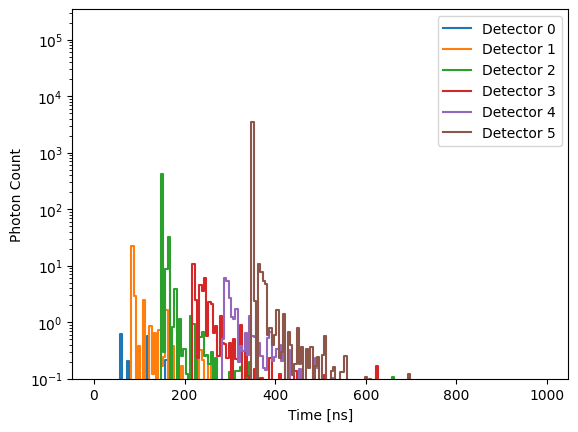

In [28]:
t = np.arange(nBins) * binSize + t0 + 0.5 * binSize
t = u.convert(t, u.ns)

plt.figure()
for i, hist in enumerate(histograms):
    plt.step(t, hist, label=f"Detector {i}")
plt.yscale("log")
plt.ylim(bottom=1.e-1)
plt.xlabel("Time [ns]")
plt.ylabel("Photon Count")
plt.legend()
plt.show()